In [1]:
from utils.fast_cmod5n import *
from glob import glob
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from scipy import stats


In [2]:
SAR_data_path = Path('SAR_data')
all_datasets = glob(str(SAR_data_path / '*.nc'))

processed_data_path = Path("processed_data")
df_wv1_unstable_gt15 = pd.read_parquet(processed_data_path / 'wv1_unstable_gt15.parquet')
df_wv2_unstable_gt15 = pd.read_parquet(processed_data_path / 'wv2_unstable_gt15.parquet')

In [3]:
def process_dataset(file_path, wdir_deg_from_north):
    """
    Process a single dataset file and return CMOD wind speed statistics
    
    Args:
        file_path: Path to the NetCDF file
        wdir_deg_from_north: Wind direction in degrees from North
            ref on convention for wdir of ER5:
                https://confluence.ecmwf.int/pages/viewpage.action?pageId=133262398
        
    Returns:
        Tuple of (median, variance, skewness, kurtosis) of CMOD wind speed
    """
    try:
        with xr.open_dataset(file_path) as ds:
            sigma0_values = ds.sigma0[0].values  
            incidence_angle = ds.incidence.values
            ground_heading = ds.ground_heading.values
            
            # Calculate phi for CMOD5n
            phi = wdir_deg_from_north - ground_heading # from cmod5n.py function: (phi in [deg] angle between azimuth and wind direction); (= D - AZM)
            # both are measured clockwise from North
            phi = np.mod(phi + 180, 360) - 180 # ensure phi is in range [-180, 180]
            
            # Calculate CMOD wind speed
            wspd_cmod = cmod5n_inverse(sigma0_values, phi, incidence_angle, iterations=10)
            
            # Calculate statistics (handling potential NaN values)
            wspd_flat = wspd_cmod.flatten()
            wspd_flat = wspd_flat[~np.isnan(wspd_flat)]  # Remove NaN values for skew and kurtosis
            
            wspd_median = np.nanmedian(wspd_cmod)
            wspd_var = np.nanvar(wspd_cmod)
            
            # Handle case where there are insufficient non-NaN values
            if len(wspd_flat) > 3:  # Need at least a few points for meaningful skew/kurtosis
                wspd_skewness = stats.skew(wspd_flat)
                wspd_kurtosis = stats.kurtosis(wspd_flat)
            else:
                wspd_skewness = np.nan
                wspd_kurtosis = np.nan
                
            return pd.Series([wspd_median, wspd_var, wspd_skewness, wspd_kurtosis])
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return pd.Series([np.nan, np.nan, np.nan, np.nan])



In [4]:
df_wv1_unstable_gt15['wdir_deg_from_north'] = np.rad2deg(df_wv1_unstable_gt15['wdir'].values) % 360
df_wv2_unstable_gt15['wdir_deg_from_north'] = np.rad2deg(df_wv2_unstable_gt15['wdir'].values) % 360


In [5]:
df_wv1_unstable_gt15['wdir_deg_from_north'] = np.rad2deg(df_wv1_unstable_gt15['wdir'].values) % 360
df_wv2_unstable_gt15['wdir_deg_from_north'] = np.rad2deg(df_wv2_unstable_gt15['wdir'].values) % 360

# Create a progress indicator
total_files = len(df_wv1_unstable_gt15) + len(df_wv2_unstable_gt15)
print(f"Processing {total_files} files...")

# Process each dataframe
results_wv1 = df_wv1_unstable_gt15.apply(
    lambda x: process_dataset(SAR_data_path / x['renamed_filename'], x['wdir_deg_from_north']), 
    axis=1,
    result_type='expand'
)
results_wv1.columns = ['wspd_cmod_median', 'wspd_cmod_var', 'wspd_cmod_skewness', 'wspd_cmod_kurtosis']

print("Finished processing wv1")

results_wv2 = df_wv2_unstable_gt15.apply(
    lambda x: process_dataset(SAR_data_path / x['renamed_filename'], x['wdir_deg_from_north']), 
    axis=1,
    result_type='expand'  
)
results_wv2.columns = ['wspd_cmod_median', 'wspd_cmod_var', 'wspd_cmod_skewness', 'wspd_cmod_kurtosis']

# Add the results to the original dataframes
df_wv1_unstable_gt15 = pd.concat([df_wv1_unstable_gt15, results_wv1], axis=1)
df_wv2_unstable_gt15 = pd.concat([df_wv2_unstable_gt15, results_wv2], axis=1)

print("Processing complete!")
    

Processing 73925 files...
Error processing SAR_data\S1A_WV_SLC__1SSV_20200508T055149_20200508T060616_032469_03C29E_0173__WV_035.nc: [Errno -101] NetCDF: HDF error: 'c:\\Users\\gui-win10\\Code\\msc-thesis\\SAR_data\\S1A_WV_SLC__1SSV_20200508T055149_20200508T060616_032469_03C29E_0173__WV_035.nc'
Error processing SAR_data\S1A_WV_SLC__1SSV_20200508T041601_20200508T043747_032468_03C294_9766__WV_015.nc: [Errno -101] NetCDF: HDF error: 'c:\\Users\\gui-win10\\Code\\msc-thesis\\SAR_data\\S1A_WV_SLC__1SSV_20200508T041601_20200508T043747_032468_03C294_9766__WV_015.nc'
Error processing SAR_data\S1A_WV_SLC__1SSV_20200508T041601_20200508T043747_032468_03C294_9766__WV_029.nc: [Errno -101] NetCDF: HDF error: 'c:\\Users\\gui-win10\\Code\\msc-thesis\\SAR_data\\S1A_WV_SLC__1SSV_20200508T041601_20200508T043747_032468_03C294_9766__WV_029.nc'
Error processing SAR_data\S1A_WV_SLC__1SSV_20200508T035531_20200508T040337_032468_03C292_D740__WV_025.nc: [Errno -101] NetCDF: HDF error: 'c:\\Users\\gui-win10\\Code\\

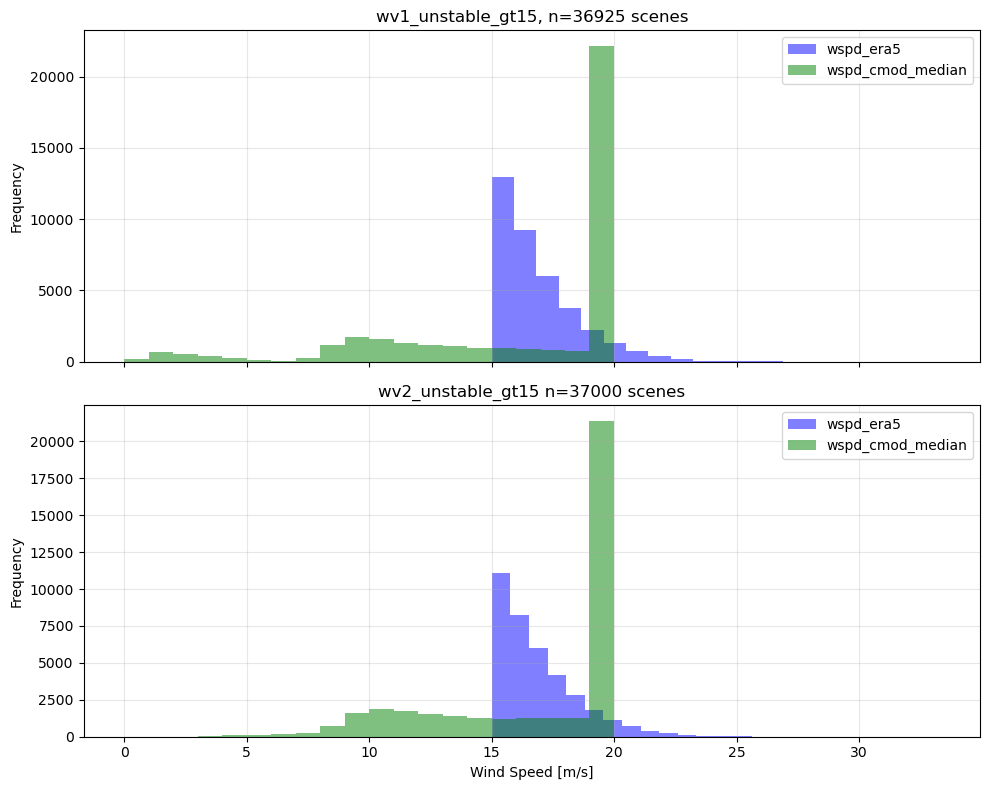

In [7]:
# Create a figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot first dataset (df_wv1_unstable_gt15) on top subplot
ax1.hist(df_wv1_unstable_gt15["wspd"], bins=20, alpha=0.5, label="wspd_era5", color="blue")
ax1.hist(df_wv1_unstable_gt15["wspd_cmod_median"], bins=20, alpha=0.5, label="wspd_cmod_median",
          color="green")
ax1.set_title(f"wv1_unstable_gt15, n={len(df_wv1_unstable_gt15)} scenes")
ax1.set_ylabel("Frequency")
ax1.legend()
ax1.grid(alpha=0.3)

# Plot second dataset (df_wv2_unstable_gt15) on bottom subplot
ax2.hist(df_wv2_unstable_gt15["wspd"], bins=20, alpha=0.5, label="wspd_era5", color="blue")
ax2.hist(df_wv2_unstable_gt15["wspd_cmod_median"], bins=20, alpha=0.5, label="wspd_cmod_median", 
         color="green")
ax2.set_title(f"wv2_unstable_gt15 n={len(df_wv2_unstable_gt15)} scenes")
ax2.set_xlabel("Wind Speed [m/s]")
ax2.set_ylabel("Frequency")
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()